**Užduotį atliko:**
Pijus Zlatkus 2110648

## Užduoties variantas:

**Klasių rinkinys:** lėktuvas (airplane), automobilis (car), žmogus (person)

### Konfigūracija užduočiai atlikti

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

GPU patikrinimas

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only one GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Memory growth allows allocating GPU memory as needed - not all at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU is available: {gpus[0]}")
    except RuntimeError as e:
        # Exception handling
        print(e)
else:
    print("No GPU is available.")

GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Duomenų užkrovimas

Semantinio segmentavimo modeliui mokinti naudojamas specialiai paruoštas duomenų rinkinys. Jam sukurti yra paimamos nuotraukos su joms priskirtomis kaukėmis. Prieš naudojant duoemnų rinkinį, nuotraukoms yra pritaikomos transformacijos kaip horizontalus apvertimas ir yra sumažinama iki 256x256 dydžio. Galiausiai duomenys yra paverčiami į tenzorius.

In [3]:
class SemanticSegmentationDataset(tf.data.Dataset):
    def _generator(image_dir, mask_dir):
        image_dir = image_dir.decode('utf-8') if isinstance(image_dir, bytes) else image_dir
        mask_dir = mask_dir.decode('utf-8') if isinstance(mask_dir, bytes) else mask_dir

        for image_file in os.listdir(image_dir):
            # Ensure image_file is a string
            image_file = image_file.decode('utf-8') if isinstance(image_file, bytes) else image_file

            if image_file.endswith(".jpg"):
                mask_file = image_file[:-4] + '_mask.png'
                image_path = os.path.join(image_dir, image_file)
                mask_path = os.path.join(mask_dir, mask_file)

                # Read and decode the image and mask files
                image = tf.io.read_file(image_path)
                image = tf.image.decode_jpeg(image, channels=3)
                mask = tf.io.read_file(mask_path)
                mask = tf.image.decode_png(mask, channels=3)
       
                yield (image, mask)

    def __new__(cls, image_dir, mask_dir):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
            ),
            args=(image_dir, mask_dir)
        )

    @staticmethod
    def preprocess(image, mask):
        image = tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.image.resize(mask, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        image = tf.image.rgb_to_grayscale(image)
        
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        mask = SemanticSegmentationDataset.encode_mask(mask)

        return image, mask

    @staticmethod
    def encode_mask(mask):
        airplane_mask = tf.cast(tf.equal(mask[:,:,0], 255), tf.int32)
        car_mask = tf.cast(tf.equal(mask[:,:,1], 255), tf.int32)
        person_mask = tf.cast(tf.equal(mask[:,:,2], 255), tf.int32)
        
        # Kaukės sudedamos kartu į vieną bendrą kaukę su 3 kaukių sluoksniais (klasių skaičius).
        encoded_mask = tf.stack([airplane_mask, car_mask, person_mask], axis=-1)
        
        # Jeigu pikselis nepriklauso neivienai klasei, tai jis yra pažimimas kaip fonas (juoda spalva)
        background_mask = tf.cast(tf.reduce_all(tf.equal(encoded_mask, 0), axis=-1, keepdims=True), tf.int32)
        
        # Sujungiamos visos kaukės su fonine kauke ir padaroma į 4 sluoksnių kaukę 4 (3 klasės + fonas).
        encoded_mask = tf.concat([background_mask, encoded_mask], axis=-1)

        return encoded_mask


def create_dataset(image_dir, mask_dir):
    dataset = SemanticSegmentationDataset(image_dir, mask_dir)
    dataset = dataset.map(SemanticSegmentationDataset.preprocess)
    return dataset

Mokymo (testavimo) ir validavimo duomenų rinkiniams sukurti, nurodomi nuotraukų ir jų kaukių aplankai. Mokymo duomenų rinkinys vėliau yra išskirtsomas į mokymo ir testavimo duomenų rinkinius.

Duomenų rinkinių proporcijos:
70% nuotraukų - mokymui,
15% nuotraukų - validacijai,
15% nuotraukų - testavimui.

In [4]:
train_image_directory = 'dataset/train/images'
train_mask_directory = 'dataset/train/masks'

val_image_directory = 'dataset/val/images'
val_mask_directory = 'dataset/val/masks'

train_dataset = create_dataset(train_image_directory, train_mask_directory)
val_dataset = create_dataset(val_image_directory, val_mask_directory)

Funkcija, patikrinanti one-hot kaukių kodavimą

Image shape: (256, 256, 1)
Image dtype: uint8
Mask shape: (256, 256, 4)
Mask dtype: int32
Is the mask one-hot encoded: True


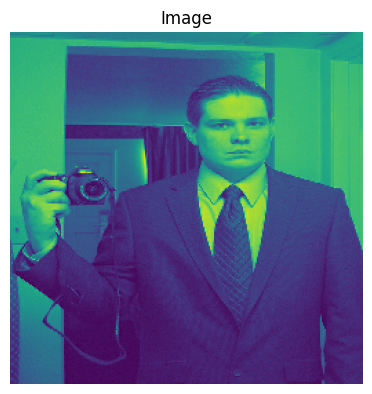

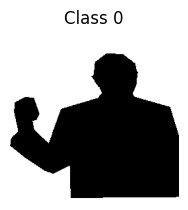

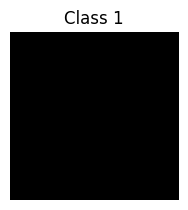

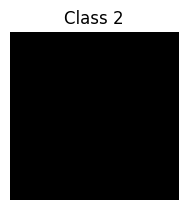

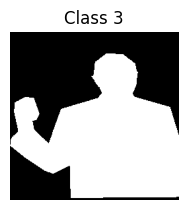

One class active per pixel: OK


In [5]:
def verify_dataset(dataset):
    for images, masks in dataset.take(1):
        image = images.numpy()
        mask = masks.numpy()

        # Verify image shape and type
        print("Image shape:", image.shape)
        print("Image dtype:", image.dtype)

        # Verify mask shape and type
        print("Mask shape:", mask.shape)
        print("Mask dtype:", mask.dtype)

        num_classes = mask.shape[-1]

        one_hot_mask = np.all(np.sum(mask, axis=-1) == 1)
        print("Is the mask one-hot encoded:", one_hot_mask)

        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        for i in range(num_classes):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, num_classes, i+1)
            plt.imshow(mask[..., i], cmap='gray')
            plt.title(f"Class {i}")
            plt.axis("off")

        plt.show()

        if one_hot_mask:
            unique_values_per_pixel = np.sum(mask, axis=-1)
            if not np.all(unique_values_per_pixel == 1):
                print("Error: Not exactly one class active per pixel.")
            else:
                print("One class active per pixel: OK")
        else:
            print("Error: Mask is not one-hot encoded.")

# Tikrinamas mokymo duomenų rinkinys
verify_dataset(train_dataset)

## Semantinio segmentavimo konvoliucinių tinklų U-Net modelis

![unet architektura.jpg](<attachment:unet architektura.jpg>)
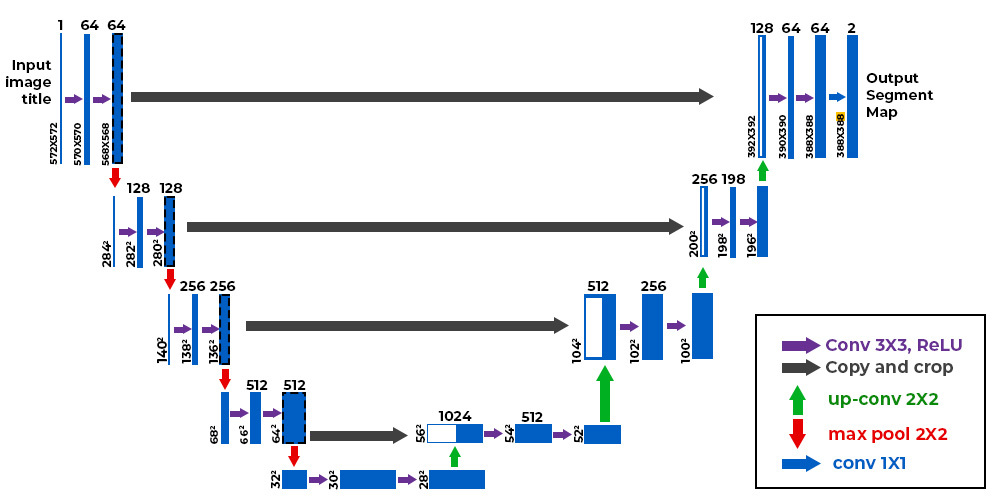

In [6]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)

    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

num_classes = 4  # 3 classes + 1 background
input_shape = (256, 256, 1)
model = unet_model(input_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

Nustatomas vieno rinkinio dydis

In [7]:
batch_size = 16

Išmaišomos nuotraukų rinkinių aibės ir suskirstomos į mažus rinkinius

In [8]:
# def count_dataset_items(dataset):
#     num_elements = 0
#     for _ in dataset:
#         num_elements += 1
#     return num_elements

# total_items_train = count_dataset_items(train_dataset)
# val_size = count_dataset_items(val_dataset)

# precalculated values
total_items_train = 4836
val_size = 662

In [9]:
test_size = int(total_items_train * 0.18)
train_size = total_items_train - test_size

train_dataset = train_dataset.shuffle(train_size)
val_dataset = val_dataset.shuffle(val_size)

train_dataset = train_dataset.skip(test_size)
test_dataset = train_dataset.take(test_size)

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
  print(f'Train batch shape: {images.shape}')

for images, labels in test_dataset.take(1):
  print(f'Test batch shape: {images.shape}')

Train batch shape: (16, 256, 256, 1)
Test batch shape: (16, 256, 256, 1)


## Modelio sukurimas, optimizavimo ir nuostolių funkcijų parinkimas

In [10]:

model.compile(optimizer=Adam(learning_rate=0.002), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.00002)

## Modelio apmokymas

In [12]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/100
248/248 [==============================] - 218s 376ms/step - loss: 0.8814 - accuracy: 0.8615 - val_loss: 0.5162 - val_accuracy: 0.8694 - lr: 0.0020
Epoch 2/100
248/248 [==============================] - 220s 368ms/step - loss: 0.4726 - accuracy: 0.8761 - val_loss: 0.5055 - val_accuracy: 0.8693 - lr: 0.0020
Epoch 3/100
248/248 [==============================] - 199s 320ms/step - loss: 0.4525 - accuracy: 0.8755 - val_loss: 0.4703 - val_accuracy: 0.8702 - lr: 0.0020
Epoch 4/100
248/248 [==============================] - 201s 362ms/step - loss: 0.4376 - accuracy: 0.8765 - val_loss: 0.4379 - val_accuracy: 0.8703 - lr: 0.0020
Epoch 5/100
248/248 [==============================] - 201s 354ms/step - loss: 0.4258 - accuracy: 0.8754 - val_loss: 0.4451 - val_accuracy: 0.8704 - lr: 0.0020
Epoch 6/100
248/248 [==============================] - 208s 369ms/step - loss: 0.4136 - accuracy: 0.8790 - val_loss: 0.4511 - val_accuracy: 0.8704 - lr: 0.0020
Epoch 7/100
248/248 [===================

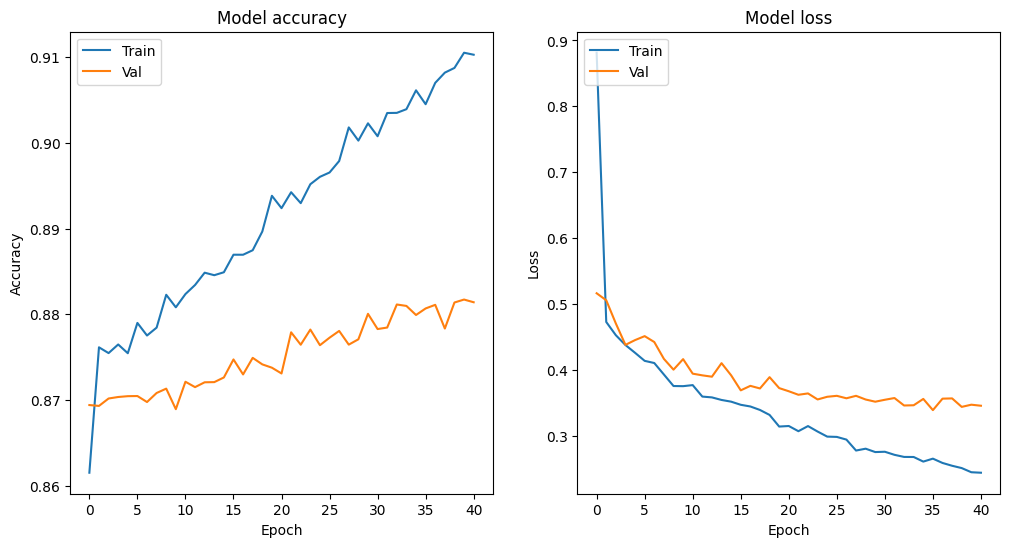

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

### Išmokyto modelio išsaugojimas

In [14]:
model.save('model.h5')

## Metrikų skaičiavimas

In [15]:
trained_model = tf.keras.models.load_model('model.h5')

In [16]:
def dice_coefficient(y_true, y_pred, num_classes):
    dice_scores = []
    for c in range(num_classes):
        y_true_f = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_f = tf.cast(tf.equal(y_pred, c), tf.float32)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        sum_y_true_y_pred = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        dice_score = (2. * intersection + 1e-5) / (sum_y_true_y_pred + 1e-5)
        dice_scores.append(dice_score)
    return tf.reduce_mean(dice_scores)  # Average over all classes

# Evaluation function adapted for TensorFlow Dataset
def evaluate_model(dataset, model, num_classes):
    micro_f1_scores = []
    macro_f1_scores = []
    dice_scores = []

    # Iterate over batches in the dataset
    for test_images, test_masks in dataset:
        predictions = model.predict(test_images)
        predicted_classes = tf.argmax(predictions, axis=-1)
        true_classes = tf.argmax(test_masks, axis=-1)

        for i in range(test_images.shape[0]):
            y_true = true_classes[i].numpy().flatten()
            y_pred = predicted_classes[i].numpy().flatten()

            # Calculate F1 scores
            micro_f1 = f1_score(y_true, y_pred, average='micro')
            macro_f1 = f1_score(y_true, y_pred, average='macro')
            micro_f1_scores.append(micro_f1)
            macro_f1_scores.append(macro_f1)

            # Calculate the Dice coefficient for multi-class
            dice_score = dice_coefficient(y_true, y_pred, num_classes)
            dice_scores.append(dice_score.numpy())  # Make sure dice_coefficient returns a Tensor

    # Calculate average scores
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)
    avg_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)

    return avg_dice, avg_micro_f1, avg_macro_f1

# Example usage with a test dataset
dice_score, micro_f1, macro_f1 = evaluate_model(test_dataset, trained_model, num_classes)
print("Dice Score:", dice_score)
print("Micro F1 Score:", micro_f1)
print("Macro F1 Score:", macro_f1)

1/1 [==============================] - 0s 404ms/step
Dice Score: 0.6708948494202789
Micro F1 Score: 0.9065900079135237
Macro F1 Score: 0.5330791164778002


Original image shape: (16, 256, 256, 1)
1/1 [==============================] - 2s 2s/step
Original image shape: (16, 256, 256, 1)
1/1 [==============================] - 0s 58ms/step
Original image shape: (16, 256, 256, 1)
1/1 [==============================] - 0s 53ms/step
Original image shape: (16, 256, 256, 1)
1/1 [==============================] - 0s 44ms/step
Original image shape: (16, 256, 256, 1)
1/1 [==============================] - 0s 51ms/step


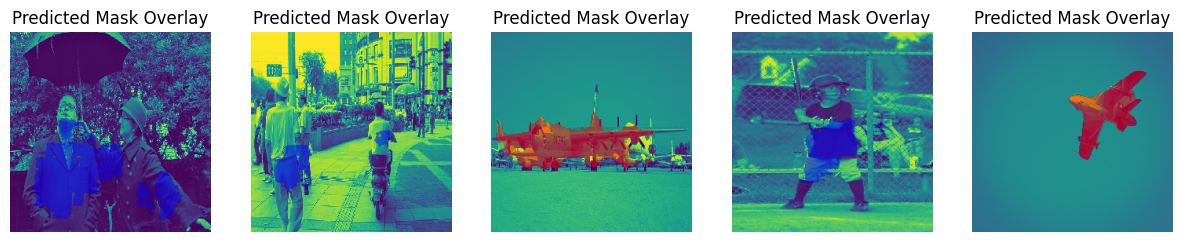

In [17]:
def plot_predictions(test_dataset, model, num_samples=5):
    class_colors = np.array([
        [0, 0, 0, 0],     # Class 0: Background (transparent)
        [255, 0, 0, 255], # Class 1: Airplane (red)
        [0, 255, 0, 255], # Class 2: Car (green)
        [0, 0, 255, 255]  # Class 3: Person (blue)
    ])

    plt.figure(figsize=(15, 5))
    
    for i, (image, mask) in enumerate(test_dataset.take(num_samples)):
        print("Original image shape:", image.shape)
        if len(image.shape) == 3:
            image = tf.expand_dims(image, axis=0)
        elif len(image.shape) == 4 and image.shape[0] != 1:
            image = image[:1]

        predictions = model.predict(image)
        predicted_mask = tf.argmax(predictions, axis=-1)
        predicted_mask = predicted_mask[0]

        color_mask = np.array(class_colors[predicted_mask.numpy().astype(np.int32)])

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image[0].numpy().astype(np.uint8))
        plt.imshow(color_mask, alpha=0.5)
        plt.title('Predicted Mask Overlay')
        plt.axis('off')

    plt.show()

plot_predictions(test_dataset, trained_model, 5)